In [58]:
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import pandas_ta as ta
import quantstats as qs
qs.extend_pandas()

import numpy as np
import datetime
from tqdm import tqdm
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn

params = {'figure.facecolor': 'w'}
plt.rcParams.update(params)

## Data Preparation

In [59]:
# Data Directory
data_dir = '/workspace/202205_idx-trading/_data/'
lq45_dir = '/workspace/202205_idx-trading/_data/20220525_lq45/'
lq45_index_file = data_dir + '20220525_lq45_index.csv'
lq45_list = '20220525_lq45-list.txt'
issi_list = '20220525_issi-list.txt'

# Prepare Stock Tickers
with open(data_dir + lq45_list, "r") as f:
    lq45_tickers = f.read().split('\n')

with open(data_dir + issi_list, "r") as f:
    issi_tickers = f.read().split('\n')

## (Alternatively) Select only Halal lq45 tickers using issi tickers
halal_lq45_tickers = [f for f in lq45_tickers if f in issi_tickers]

## Prepare active tickers for international codes
active_tickers_international = [f + '.JK' for f in lq45_tickers]
halal_active_tickers_international = [f + '.JK' for f in halal_lq45_tickers]

In [60]:
# Read downloaded stock Adjusted Close Price data
lq45_df_dict = {}
for ticker in tqdm(active_tickers_international):
    lq45_df_dict[ticker] = pd.read_csv(lq45_dir + ticker + '.csv')
    
lq45_index_data = pd.read_csv(lq45_index_file)

100%|███████████████████████████████████████████████████████████████████| 45/45 [00:02<00:00, 22.33it/s]


In [61]:
# Do Some basic data Operations (Fill NaN, take only certain data range, generate in sample an dout of sample data)
date_start = '2021-01-01'
date_breakpoint = '2022-01-01'

lq45_in_df = {}
lq45_out_df = {}
for ticker in tqdm(active_tickers_international):
    # Fill NaN values with the earliest data
    lq45_df_dict[ticker].fillna(method='bfill', axis=0, inplace=True)
    
    # Take In Sample and Out Sample Data
    lq45_df_dict[ticker]['Date'] = pd.to_datetime(lq45_df_dict[ticker]['Date'])
    lq45_in_df[ticker] = lq45_df_dict[ticker][(lq45_df_dict[ticker]['Date'] >= date_start) & 
                                                (lq45_df_dict[ticker]['Date'] < date_breakpoint)]
    lq45_out_df[ticker] = lq45_df_dict[ticker][lq45_df_dict[ticker]['Date'] >= date_breakpoint]
    
    # Reset Index After Dropped
    lq45_in_df[ticker] = lq45_in_df[ticker].reset_index(drop=True)
    lq45_out_df[ticker] = lq45_in_df[ticker].reset_index(drop=True)

# Do the same for lq45 index data, and add to df dictionary
lq45_index_data.fillna(method='bfill', axis=0, inplace=True)
lq45_index_data['Date'] = pd.to_datetime(lq45_index_data['Date'])
lq45_in_df['LQ45'] = lq45_index_data[(lq45_index_data['Date'] >= date_start) & 
                                (lq45_index_data['Date'] < date_breakpoint)]
lq45_out_df['LQ45'] = lq45_index_data[lq45_index_data['Date'] >= date_breakpoint]
lq45_in_df['LQ45'] = lq45_index_in.reset_index(drop=True)
lq45_out_df['LQ45'] = lq45_index_out.reset_index(drop=True)

100%|███████████████████████████████████████████████████████████████████| 45/45 [00:00<00:00, 58.76it/s]


## Data Exploration
We will test for cointegration on in-sample data

In [71]:
# Prepare LQ45 Stock Indexes of the Same Group
energy_and_mining = ['BRPT.JK', 'HRUM.JK', 'MEDC.JK', 'PGAS.JK', 'TPIA.JK', 'ADRO.JK', 'ITMG.JK', 'PTBA.JK']
precious_rocks = ['INCO.JK', 'MDKA.JK', 'ANTM.JK']
retail = ['AMRT.JK', 'UNVR.JK', 'ERAA.JK', 'ASII.JK']
food_agri = ['CPIN.JK', 'JPFA.JK', 'ICBP.JK', 'INDF.JK']
paper = ['TKIM.JK', 'INKP.JK']
finance = ['BBCA.JK', 'BBNI.JK', 'BBRI.JK', 'BBTN.JK', 'BMRI.JK', 'BFIN.JK']
media = ['EMTK.JK', 'MNCN.JK']
telcom = ['EXCL.JK', 'TLKM.JK', 'TBIG.JK', 'TOWR.JK']
tobacco = ['GGRM.JK', 'HMSP.JK']
construction = ['INTP.JK', 'PTPP.JK', 'SMGR.JK', 'UNTR.JK', 'WIKA.JK', 'WSKT.JK']
medical = ['KLBF.JK', 'MIKA.JK']

In [67]:
from statsmodels.tsa.stattools import coint

def find_coint_pairs(df_dict, tickers, plot=True, alpha=0.05):
    '''
    Finds cointegrated pairs from df_dict serial data, based on given tickers.
    '''
    n = len(tickers)
    score_matrix = np.zeros((n, n))
    pvalue_matrix = np.ones((n, n))
    pairs = []
    
    for i in tqdm(range(0, n)):
        for j in range(i+1, n):
            S1 = df_dict[tickers[i]]['Adj Close']
            S2 = df_dict[tickers[j]]['Adj Close']
            result = coint(S1, S2)
            score = result[0]
            pvalue = result[1]
            score_matrix[i, j] = score
            pvalue_matrix[i, j] = pvalue
            if pvalue < alpha:
                pairs.append([tickers[i], tickers[j]])
                pairs.append(pvalue)
                
    if plot:
        seaborn.heatmap(pvalue_matrix, xticklabels=tickers, yticklabels=tickers, cmap='RdYlGn_r'
                    , mask = (pvalue_matrix >= alpha)
                    )
                
    return score_matrix, pvalue_matrix, pairs

100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  5.09it/s]


[['INTP.JK', 'PTPP.JK'], 0.019205139617439058, ['INTP.JK', 'WIKA.JK'], 0.02959968730035762, ['SMGR.JK', 'WSKT.JK'], 0.046038537071871645]


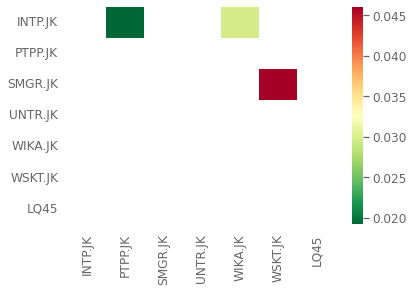

In [82]:
# Explore Cointegration
tickers = construction.copy()
tickers.append('LQ45')
_, pval_mat, pairs = find_coint_pairs(lq45_in_df, tickers, alpha=0.05)
print(pairs)

In [94]:
# List of Cointegrated Pairs (LQ45 2020-2021, Tested w/ stattools.coint)
coint_pairs = [['HRUM.JK', 'ADRO.JK'],
             ['PGAS.JK', 'LQ45'],
             ['TPIA.JK', 'ITMG.JK'],
             ['INCO.JK', 'ANTM.JK'],
             ['AMRT.JK', 'UNVR.JK'],
             ['CPIN.JK', 'JPFA.JK'],
             ['ICBP.JK', 'LQ45'],
             ['BBNI.JK', 'BMRI.JK'],
             ['BBRI.JK', 'BBTN.JK'],
             ['GGRM.JK', 'HMSP.JK'],
             ['INTP.JK', 'PTPP.JK'],
             ['INTP.JK', 'WIKA.JK'],
             ['SMGR.JK', 'WSKT.JK'],
             ['KLBF.JK', 'LQ45']]

In [106]:
import statsmodels.api as sm

def calc_beta(S1, S2):
    '''
    Calculate beta from two price series by doing regression.
    '''
    S1 = sm.add_constant(S1)
    results = sm.OLS(S2, S1).fit()
    S1 = S1['Adj Close']
    b = results.params['Adj Close']
    
    return b

def calc_half_life(S):
    '''
    Calculate half life from a price series
    '''
    S_lag = S.shift(periods=1).iloc[1:]
    S_diff = S.iloc[1:] - S_lag

    S_lag = sm.add_constant(S_lag)
    results = sm.OLS(S_diff, S_lag).fit()
    S_lag = S_lag['Adj Close']
    lbd = results.params['Adj Close']

    half_life = -np.log(2) / lbd
    
    return lbd, half_life

In [122]:
# Calculate Half Life for All Pairs

hl_df = pd.DataFrame(columns=['ticker_1', 'ticker_2', 'beta', 'lambda', 'half_life'])
for pair in tqdm(coint_pairs):
    # Regression to get Beta for Price Spread Model
    S1 = lq45_in_df[pair[0]]['Adj Close']
    S2 = lq45_in_df[pair[1]]['Adj Close']
    b = calc_beta(S1, S2)
    spread = S2 - b * S1
    
    # Ornstein-Uhlenbeck Formula to Calculate Half Life
    lbd, half_life = calc_half_life(spread)
    
    # Append to df
    buff = pd.DataFrame({"ticker_1": [pair[0]],
                          "ticker_2": [pair[1]],
                          "beta": [b],
                          "lambda": [lbd],
                          "half_life": [half_life]})
    hl_df = pd.concat([hl_df, buff])

hl_df = hl_df.reset_index(drop=True)

hl_df

100%|███████████████████████████████████████████████████████████████████| 14/14 [00:01<00:00,  7.03it/s]


,ticker_1,ticker_2,beta,lambda,half_life
0,HRUM.JK,ADRO.JK,0.118786,-0.042583,16.27739
1,PGAS.JK,LQ45,0.214573,-0.277809,2.495054
2,TPIA.JK,ITMG.JK,-2.136932,-0.044811,15.468066
3,INCO.JK,ANTM.JK,0.286496,-0.175586,3.947627
4,AMRT.JK,UNVR.JK,-4.559573,-0.08767,7.906315
5,CPIN.JK,JPFA.JK,0.402763,-0.093812,7.388698
6,ICBP.JK,LQ45,0.088955,-0.087703,7.903354
7,BBNI.JK,BMRI.JK,0.602237,-0.115857,5.982757
8,BBRI.JK,BBTN.JK,0.61375,-0.100368,6.906054
9,GGRM.JK,HMSP.JK,0.032803,-0.016884,41.052341


## Strategy

### Baseline Strategy

Buy and Hold LQ45

In [5]:
# Simple buy and hold strategy
b_df = lq45_index_data.copy()

b_df['signal'] = ''
b_df['close'] = b_df['Adj Close']
b_df = b_df[['Date', 'close', 'signal']]
b_df = b_df.reset_index(drop=True)

b_df['signal'][0] = 'buy'
b_df['signal'][len(b_df)-1] = 'sell'

def calc_returns(df):
    '''
    Calculate returns and cumulative returns per entry on dataframe.
    Is strategy specific.
    '''
    last_signal = ''
    df['return'] = ''
    for i in range(0, len(df)):
        if last_signal == 'buy':
            df["return"][i] = (df['close'][i] / df['close'][i-1]) - 1
        elif last_signal == 'sell':
            df["return"][i] = 0
        else:
            df["return"][i] = 0
        
        if not(df["signal"][i] == ''):
            last_signal = df["signal"][i] 

    df["cum_return"] = (1 + df["return"]).cumprod()
    return df

### Trading Strategy
Simple Bollinger Band-based long only strategy adapted from:
https://github.com/quantopian/research_public/blob/master/notebooks/lectures/Introduction_to_Pairs_Trading/notebook.ipynb

In [6]:
from statsmodels.regression.rolling import RollingOLS

# Define Strategy
def strategy(df_dict, pair, lookback, beta_lookback=30, std=1):
    
    # Take the relevant price series
    df_proc = pd.concat([df_dict[pair[0]]['Date'], df_dict[pair[0]]['Adj Close'], df_dict[pair[1]]['Adj Close']], 
                            axis=1,
                            keys=['Date', pair[0], pair[1]])
    
    # Calculate Rolling Price Spread
    S1 = df_proc[pair[0]]
    S2 = df_proc[pair[1]]
    
    S1_indep = sm.add_constant(S1)
    result = RollingOLS(S2, S1_indep, window=beta_lookback).fit()
    
    ## shift 1 period to prevent lookahead bias
    rolling_beta = result.params[pair[0]].shift(periods=1)
    
    ## add Rolling Beta to main df
    df_proc['beta'] = rolling_beta
    
    # Calculate the rolling spread
    df_proc['spread'] = df_proc[pair[1]] - df_proc['beta'] * df_proc[pair[0]]
    
    # Generate Technical Indicators (BBand and SMA)
    df_proc.set_index('Date')
    sma = ta.sma(df_proc['spread'], length=lookback)
    bbands = ta.bbands(df_proc['spread'], length=lookback, std=std)
    
    bbands_upper_cname = 'BBU' + '_' + str(lookback) + '_' + str(std) + '.0'
    bbands_lower_cname = 'BBL' + '_' + str(lookback) + '_' + str(std) + '.0'
    bbands_mid_cname = 'BBM' + '_' + str(lookback) + '_' + str(std) + '.0'
    
    df_proc['spread_BBU'] = bbands[bbands_upper_cname]
    df_proc['spread_BBL'] = bbands[bbands_lower_cname]
    df_proc['spread_BBM'] = bbands[bbands_mid_cname]
    df_proc['spread_SMA'] = sma
    
    # TODO - Generate Signals
    
    ## Signal Rule
    long_signal = lambda price, bbl: (price >= bbl)
    short_signal = lambda price, bbu: (price <= bbu) # might be better to set absolute differences    
    
    ## Generate Signals
    last_signal = ''
    for i in tqdm(range(0, len(df_proc))):
        if i == 0:
            df_proc['signal'][i] = ''
        
        elif last_signal == '':
            if buy_signal(df_proc['close'][i], df_proc['EMA_10'][i]):
                df_proc['signal'][i] = 'buy'
                last_signal = 'buy'
            elif sell_signal(df_proc['close'][i], df_proc['EMA_10'][i]):
                df_proc['signal'][i] = 'sell'
                last_signal = 'sell'
            else:
                df_proc['signal'][i] = ''
            
        elif last_signal == 'buy':
            if sell_signal(df_proc['close'][i], df_proc['EMA_10'][i]):
                df_proc['signal'][i] = 'sell'
                last_signal = 'sell'
            else:
                df_proc['signal'][i] = ''
            
        elif last_signal == 'sell':
            if buy_signal(df_proc['close'][i], df_proc['EMA_10'][i]):
                df_proc['signal'][i] = 'buy'
                last_signal = 'buy'
            else:
                df_proc['signal'][i] = ''
    
    return df_proc

    # TODO - Returns is then: (Short Spread) returns(S2 Buy price, S2 Close Price). (Long Spread) returns(S1 Buy price, S1 Close Price). 
    # Where buy price is within 1 std, and sell is 0 std.

In [7]:
# Run Strategy
s_df = strategy(lq45_index_data)

100%|█████████████████████████████████████████████████████████████| 2519/2519 [00:00<00:00, 3230.92it/s]


## Evaluation

### Backtest for All Pairs
Backtest is done on out of sample data

In [ ]:
# Iterative Backtest per Pair


In [ ]:
# (Optional) Cointegration Test on Out of Sample Data


In [ ]:
# Productive Pairs


### Calculate Metrics for Strategy

In [9]:
# Prepare for Metric Calculation
s_df = calc_returns(s_df)
s_ret = s_df.set_index('Date')['return'].astype(float)

b_df = calc_returns(b_df)
b_ret = b_df.set_index('Date')['return'].astype(float)

                    Strategy    Benchmark
------------------  ----------  -----------
Start Period        2012-01-13  2012-01-13
End Period          2022-05-25  2022-05-25
Risk-Free Rate      2.5%        2.5%
Time in Market      58.0%       100.0%

Cumulative Return   -31.18%     45.45%
CAGR﹪              -3.54%      3.68%

Sharpe              -0.4        0.17
Prob. Sharpe Ratio  2.71%       35.99%
Sortino             -0.55       0.23
Sortino/√2          -0.39       0.17
Omega               0.91        0.91

Max Drawdown        -40.59%     -49.94%
Longest DD Days     3291        1582

Gain/Pain Ratio     -0.05       0.05
Gain/Pain (1M)      -0.18       0.31

Payoff Ratio        0.91        0.91
Profit Factor       0.95        1.05
Common Sense Ratio  0.88        1.07
CPC Index           0.44        0.51
Tail Ratio          0.92        1.01
Outlier Win Ratio   9.72        3.37
Outlier Loss Ratio  3.98        3.47

MTD                 -5.48%      -6.99%
3M                  1.69%       3.

In [ ]:
# Calculate Metrics
qs.reports.metrics(returns=s_ret, benchmark=b_ret, rf=0.025, mode='basic')

### Plot Relevant Visualizations

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


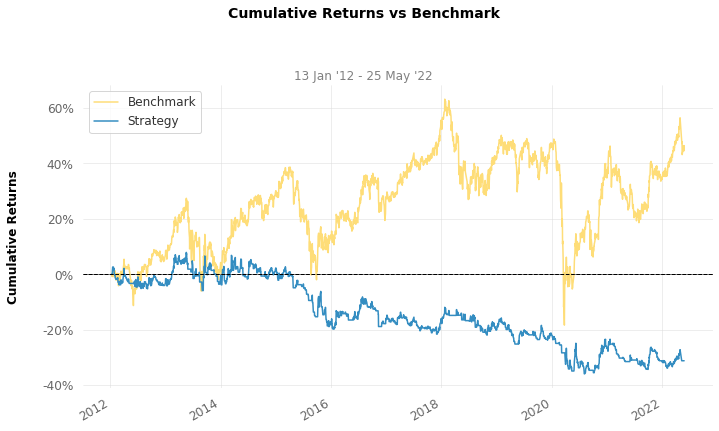

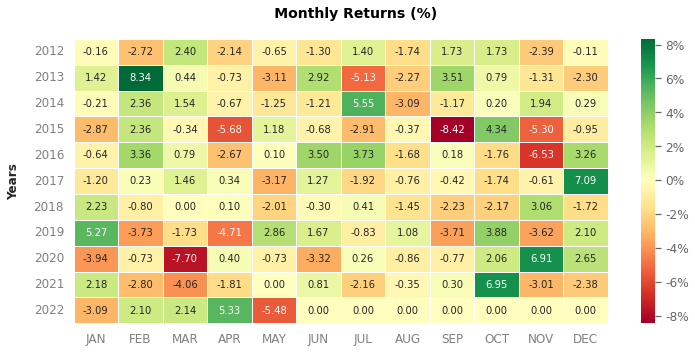

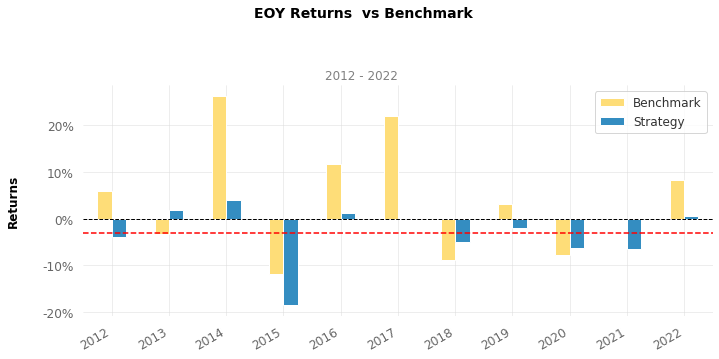

In [10]:
# Returns Visualization
qs.plots.returns(s_ret, b_ret)
qs.plots.monthly_heatmap(s_ret)
qs.plots.yearly_returns(s_ret, b_ret)

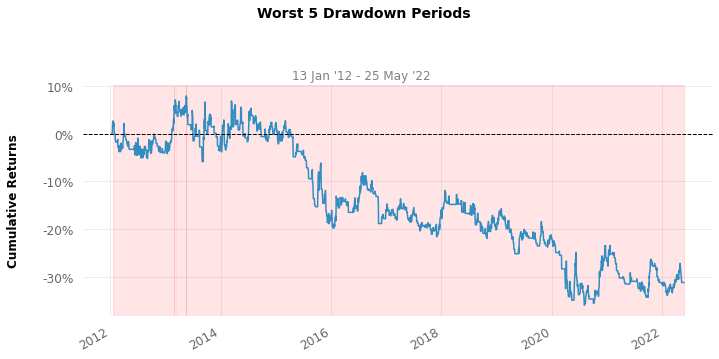

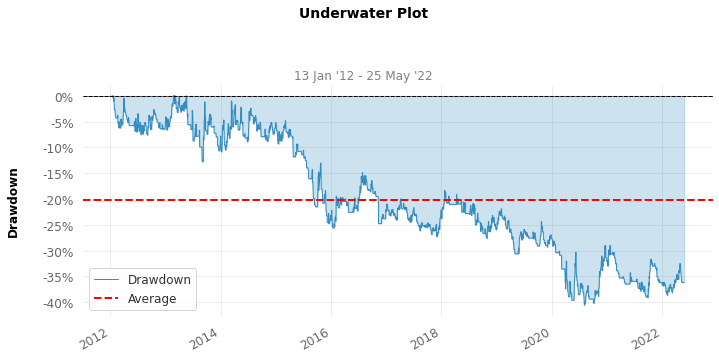

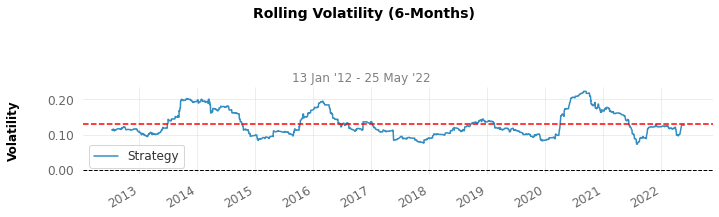

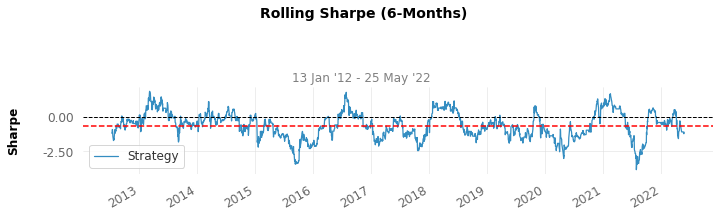

In [11]:
# Risk Visualization
qs.plots.drawdowns_periods(s_ret)
qs.plots.drawdown(s_ret)
qs.plots.rolling_volatility(s_ret)
qs.plots.rolling_sharpe(s_ret, rf=0.025)